### Create and Save Dataset

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import yaml
import seaborn as sns
import pandas as pd
from skimage.measure import regionprops

In [2]:
# beta-catenin=2, cd20=9, cd209=10, cd 56=16, cd31=12, cd 8=19, FoxP3=24, 
# H327me3 =25, H3K9ac =26, MPO=34, Keratin6=31, SMA=41

In [3]:
def normalize_point(X):
    channel_maxes = np.amax(X, axis=(0,1,2))
    for m in range(len(channel_maxes)):
        if channel_maxes[m] != 0:
            X[0,:,:,m] /= channel_maxes[m]
    return X

In [4]:
def create_new_X(X, channels=[2, 9, 10, 16, 12, 19, 24, 25, 26, 34, 31, 41]):
    #select just for channels of interest
    new_data = np.take(X, channels, axis=3)
    #normalize data
    normalized_data = normalize_point(new_data)
    return normalized_data

In [6]:
def pad_along_axis(arr, target_length, axis):
    pad_size = target_length - arr.shape[axis]
    if pad_size <= 0:
        return arr
    npad = [(0, 0)] * arr.ndim
    npad[axis] = (0, pad_size)
    return np.pad(arr, pad_width=npad, mode='constant', constant_values=0)

In [7]:
def create_and_save_data(imgs, mask, cell_dict, fn):
    regions = regionprops(mask, imgs[0,:,:,:])
    # iterate through every cell
    for cell_num in cell_dict.keys():
        # only want to look at certain cell types (not background, etc.)
        cell_type = cell_dict[cell_num]
        if cell_type not in (0,1,17):
            label = np.zeros(15)
            # only look at values of that specific cell
            coords = regions[cell_num - 1].coords
            cropped_view = imgs[0,:,:,:][(coords[:,0], coords[:,1])]
            if cropped_view.shape[0] < 256:
                cropped_view = pad_along_axis(cropped_view, 256, 0)
            else:
                cropped_view = cropped_view[:256, :]
            label[cell_type-2] +=1
            np.savez('processed_data/' + fn[-11:-4] + '_' + str(cell_num) + '.npz', x=cropped_view, y=label)
            


In [8]:
def create_dataset(file_list):
    for fn in file_list:
        with np.load(fn, allow_pickle=True) as f:
            cell_dict = f['cell_types'].item()
            X = f['X']
            mask = f['y'][0,:,:,0]
        imgs = create_new_X(X)
        create_and_save_data(imgs, mask, cell_dict, fn)
        print(fn)
        

In [9]:
# extracting all the data
data_files = []
for f in listdir("keren/sample_data/"):
    if '.npz' in f:
        data_files.append('keren/sample_data/' + f) 

In [10]:
create_dataset(data_files)

keren/sample_data/Point09.npz
keren/sample_data/Point30.npz
keren/sample_data/Point25.npz
keren/sample_data/Point20.npz
keren/sample_data/Point38.npz
keren/sample_data/Point01.npz
keren/sample_data/Point04.npz
keren/sample_data/Point32.npz
keren/sample_data/Point22.npz
keren/sample_data/Point31.npz
keren/sample_data/Point15.npz
keren/sample_data/Point28.npz
keren/sample_data/Point27.npz
keren/sample_data/Point40.npz
keren/sample_data/Point10.npz
keren/sample_data/Point36.npz
keren/sample_data/Point08.npz
keren/sample_data/Point19.npz
keren/sample_data/Point39.npz
keren/sample_data/Point05.npz
keren/sample_data/Point41.npz
keren/sample_data/Point13.npz
keren/sample_data/Point23.npz
keren/sample_data/Point18.npz
keren/sample_data/Point17.npz
keren/sample_data/Point33.npz
keren/sample_data/Point02.npz
keren/sample_data/Point35.npz
keren/sample_data/Point06.npz
keren/sample_data/Point12.npz
keren/sample_data/Point26.npz
keren/sample_data/Point24.npz
keren/sample_data/Point16.npz
keren/samp

### Load Dataset

In [11]:
# extracting all the data
file_list = []
for f in listdir("processed_data/"):
    if '.npz' in f:
        file_list.append('processed_data/' + f) 

with open("keren/meta.yaml", 'r') as meta_f:
    meta_data = yaml.safe_load(meta_f)
cell_types_list = list(meta_data['cell_types'].values())

### Train model

In [12]:
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model

import sklearn
import sklearn.model_selection

from tensorflow.keras.optimizers.legacy import Adam

2023-04-23 08:33:53.147115: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 08:33:57.969243: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 08:33:58.358140: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 08:33:58.361463: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but

In [13]:
def create_fc_classifier():
    inputs = Input((256, 12),
                   name='fc_classifier_input')
    x = Flatten()(inputs)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(64)(x)
    x = Activation('relu')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Dense(15)(x)
    x = Softmax(axis=-1)(x)
    model = Model(inputs=inputs, outputs=x)
    return model

fc_classifier = create_fc_classifier()

2023-04-23 08:33:58.568013: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-23 08:33:58.569048: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 08:33:58.572358: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-23 08:33:58.575256: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but

In [14]:
# Define the loss function
loss_function = tf.keras.losses.CategoricalCrossentropy() 

# Define the training algorithm
fc_optimizer = Adam(learning_rate=1e-3, clipnorm=0.001)

# Compile the model
fc_classifier.compile(optimizer=fc_optimizer, 
                          loss=loss_function)

In [15]:
# split training (70%), validation (15%), and test data (15%)

np.random.shuffle(file_list)
train_files = file_list[:int(len(file_list)*.7)]
val_files = file_list[int(len(file_list)*.7):int(len(file_list)*.85)]
test_files = file_list[:int(len(file_list)*.85):]

2023-04-23 08:35:34.114615: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1750671360 exceeds 10% of free system memory.
2023-04-23 08:35:36.101187: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1750671360 exceeds 10% of free system memory.


4453/4453 [==============================] - 8s 1ms/step


<Axes: >

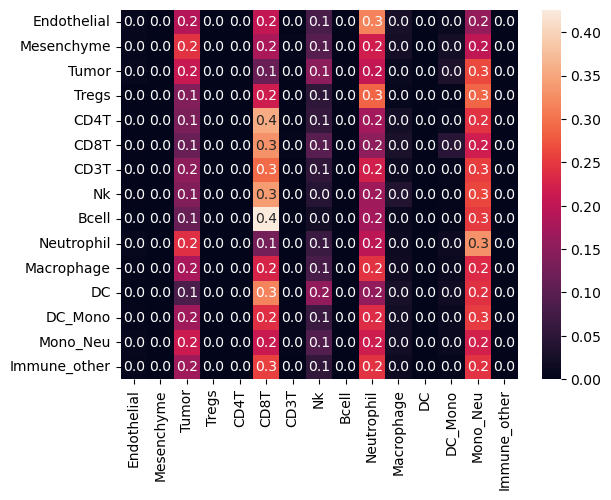

In [16]:
# Looking at confusion matrix based on initial model weights
# Assuming keras does a fairly good job of initializing 'good' weights

x_test = []
y_test = []
for i in range(len(test_files)):
    data = np.load(test_files[i])
    X, y = data['x'], data['y']
    x_test.append(X)
    y_test.append(y)
x_test = np.array(x_test)
y_test = np.array(y_test)

#get labels
y_test = np.argmax(y_test, axis=-1)

#predict
y_pred = fc_classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)

vals = np.arange(15)
totals = []
for v in vals:
    num = len(np.where(y_test==v)[0])
    if num!=0:
        totals.append(num)
    else:
        totals.append(1)
totals=np.array(totals)

new_conf_mat = []
for i in range(len(conf_mat)):
    new_conf_mat.append(conf_mat[i] /totals[i])

import seaborn as sns

sns.heatmap(np.array(new_conf_mat), annot=True, fmt=".1f", xticklabels = cell_types_list[2:17], yticklabels = cell_types_list[2:17])

In [17]:
def data_iterator(file_list, batch_size):
    while True:
        np.random.shuffle(file_list)
        m = 0
        x_batch = []
        y_batch = []
        for i in range(batch_size):
            data = np.load(file_list[m])
            X, y = data['x'], data['y']
            x_batch.append(X)
            y_batch.append(y)
            m+=1
        yield np.array(x_batch), np.array(y_batch)
            


In [18]:
model_path = 'saved_models/'

In [19]:
# Create data iterator
batch_size = 32
train_iterator = data_iterator(train_files, batch_size)
val_iterator = data_iterator(val_files, batch_size)

steps_per_epoch = len(train_files) // batch_size
val_steps_per_epoch = len(val_files) // batch_size

# epochs
num_epochs = 10
best_val_loss = 10
for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_loss = 0
    val_loss = 0
    if epoch == 0:
        for step in range(val_steps_per_epoch):
            batch_x, batch_y = next(val_iterator)
            val_loss += fc_classifier.test_on_batch(batch_x, batch_y)
        print(f'initial val loss: {val_loss/val_steps_per_epoch}')
        val_loss = 0
    for step in range(steps_per_epoch):
        batch_x, batch_y = next(train_iterator)
        train_loss += fc_classifier.train_on_batch(batch_x, batch_y)
    for step in range(val_steps_per_epoch):
        batch_x, batch_y = next(val_iterator)
        val_loss += fc_classifier.test_on_batch(batch_x, batch_y)
    train_loss /= steps_per_epoch
    val_loss /= val_steps_per_epoch
    if val_loss <= best_val_loss:
        best_val_loss = val_loss
        fc_classifier.save(model_path)  
    print(f'Train loss: {train_loss:.4f} | Val loss: {val_loss:.4f}')

Epoch 1/10
initial val loss: 2.6946596798623443
INFO:tensorflow:Assets written to: saved_models/assets
Train loss: 1.0629 | Val loss: 1.0128
Epoch 2/10
INFO:tensorflow:Assets written to: saved_models/assets
Train loss: 0.9471 | Val loss: 0.9805
Epoch 3/10
Train loss: 0.9168 | Val loss: 0.9869
Epoch 4/10
Train loss: 0.8797 | Val loss: 0.9855
Epoch 5/10
Train loss: 0.8626 | Val loss: 1.0266
Epoch 6/10
Train loss: 0.8317 | Val loss: 1.0342
Epoch 7/10
Train loss: 0.8132 | Val loss: 1.0548
Epoch 8/10
Train loss: 0.7999 | Val loss: 1.0621
Epoch 9/10
Train loss: 0.7746 | Val loss: 1.0800
Epoch 10/10
Train loss: 0.7547 | Val loss: 1.1022


#### Load and Test Model

In [20]:
# Loading model with best validation loss
fc_classifier = tf.keras.models.load_model(model_path)

In [22]:
# Final confusion matrix
y_pred = fc_classifier.predict(x_test)
y_pred = np.argmax(y_pred, axis=-1)

conf_mat = sklearn.metrics.confusion_matrix(y_test, y_pred)

new_conf_mat = []
for i in range(len(conf_mat)):
    new_conf_mat.append(conf_mat[i] /totals[i])

2023-04-23 09:07:54.540918: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1750671360 exceeds 10% of free system memory.


4453/4453 [==============================] - 6s 1ms/step


[Text(0.5, 23.38159722222222, 'Predicted'),
 Text(50.58159722222221, 0.5, 'Actual')]

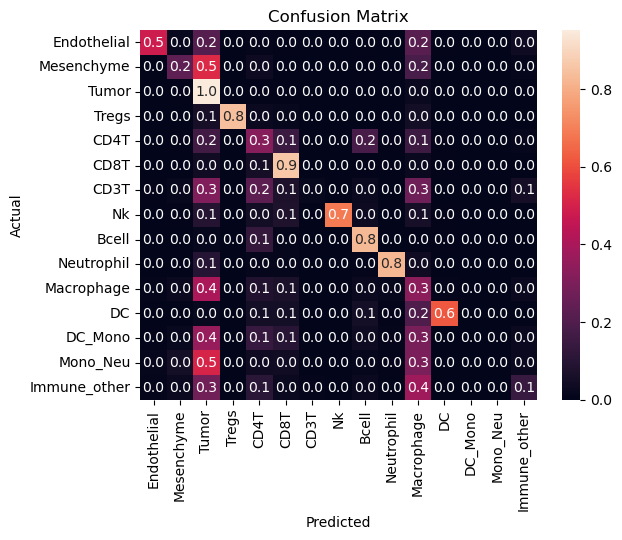

In [28]:
plt.figure()
plt.title('Confusion Matrix')
fig = sns.heatmap(np.array(new_conf_mat), annot=True, fmt=".1f", xticklabels = cell_types_list[2:17]
                  , yticklabels = cell_types_list[2:17])
fig.set(xlabel='Predicted', ylabel='Actual')

In [37]:
# frequencies of cell types
freqs = totals / np.sum(totals)
for i in range(len(cell_types_list[2:17])):
    print(f"{cell_types_list[i+2]}: {freqs[i]}")


Endothelial: 0.01067593177511055
Mesenchyme: 0.03821155330946866
Tumor: 0.5077560188109778
Tregs: 0.007692847617042184
CD4T: 0.06683512318382817
CD8T: 0.08504948410191619
CD3T: 0.020193724994735734
Nk: 0.003572681968133642
Bcell: 0.050066680704709765
Neutrophil: 0.01691584193163473
Macrophage: 0.10830350249175265
DC: 0.006485575910718046
DC_Mono: 0.025598371587000773
Mono_Neu: 0.015624341966729838
Immune_other: 0.03701831964624131


#### Putting it all together

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from os import listdir
from os.path import isfile, join
import yaml
import seaborn as sns
import pandas as pd
from skimage.measure import regionprops

import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
from tensorflow.keras.layers import Input, Flatten, Dense, Activation, BatchNormalization, Conv2D, MaxPool2D, Softmax
from tensorflow.keras import Model

import sklearn
import sklearn.model_selection

from tensorflow.keras.optimizers.legacy import Adam

import seaborn as sns

In [14]:
def normalize_point(X):
    channel_maxes = np.amax(X, axis=(0,1,2))
    for m in range(len(channel_maxes)):
        if channel_maxes[m] != 0:
            X[0,:,:,m] /= channel_maxes[m]
    return X

def create_new_X(X, channels=[2, 9, 10, 16, 12, 19, 24, 25, 26, 34, 31, 41]):
    #select just for channels of interest
    new_data = np.take(X, channels, axis=3)
    #normalize data
    normalized_data = normalize_point(new_data)
    return normalized_data

def pad_along_axis(arr, target_length, axis):
    pad_size = target_length - arr.shape[axis]
    if pad_size <= 0:
        return arr
    npad = [(0, 0)] * arr.ndim
    npad[axis] = (0, pad_size)
    return np.pad(arr, pad_width=npad, mode='constant', constant_values=0)

def process_data(imgs, mask, cell_dict):
    regions = regionprops(mask, imgs[0,:,:,:])
    cells = []
    cell_nums = []
    # iterate through every cell
    for cell_num in cell_dict.keys():
        # only want to look at certain cell types (not background, etc.)
        cell_type = cell_dict[cell_num]
        if cell_type not in (0,1,17):
            label = np.zeros(15)
            # only look at values of that specific cell
            coords = regions[cell_num - 1].coords
            cropped_view = imgs[0,:,:,:][(coords[:,0], coords[:,1])]
            if cropped_view.shape[0] < 256:
                cropped_view = pad_along_axis(cropped_view, 256, 0)
            else:
                cropped_view = cropped_view[:256, :]
            cells.append(cropped_view)
            cell_nums.append(cell_num)
        
    return np.array(cells), np.array(cell_nums)

In [20]:
def test_on_data(X, y, cell_dict, model=fc_classifier):
    cell_dict = cell_dict.item()
    processed_X = create_new_X(X)
    processed_data, cell_nums = process_data(processed_X, y, cell_dict)
    
    y_pred = fc_classifier(processed_data)
    y_pred = np.argmax(y_pred, axis=-1)
    
    prediction_dict = {}
    
    for i in range(len(cell_nums)):
        # maps the cell number (segmentation mask ID) to prediction
        prediction_dict[cell_nums[i]] = y_pred[i]+2
    
    return prediction_dict

In [22]:
# Example on how to use:

#Load data
fn = 'keren/sample_data/Point01.npz'

with np.load(fn, allow_pickle=True) as f:
    cell_dict = f['cell_types']
    X = f['X']
    y = f['y'][0,:,:,0]

#Load model   
model_path = 'saved_models/'
fc_classifier = tf.keras.models.load_model(model_path)

#create predictions
#does not predict on background, unidentified, or failed harmonization cells
prediction_dict = test_on_data(X, y, cell_dict)